<a href="https://colab.research.google.com/github/MaximeSzymanski/StocksClustering/blob/dev/clustering_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Stocks with a Self-Organizing Map (SOM)

In this project, we aim to cluster stocks based on their daily price variation using a Self-Organizing Map (SOM) algorithm. The SOM is a type of artificial neural network that can learn the underlying structure of high-dimensional data and group similar data points together.

To begin, we'll retrieve the list of tickers for the S&P600 companies from Wikipedia using web scraping techniques with Python libraries such as BeautifulSoup and requests. The S&P600 is an index of small-cap stocks in the United States, making it a relevant choice for this project.

Next, we'll use the yfinance API to collect historical stock prices for each company in the S&P600 over the past five years. We'll then preprocess and clean the data to ensure that each stock has equal weight in the clustering analysis.

After the data has been cleaned, we'll compute the daily returns for each stock by calculating the percentage change in price from one day to the next. This allows us to capture the relative price variation over time, which is an important factor in clustering stocks.

Finally, we'll use the SOM algorithm to cluster the stocks into groups with similar daily price variation. This will enable us to identify patterns and similarities between the stocks that may not be immediately apparent from raw price data.

Overall, this project will provide a step-by-step guide to clustering stocks with a SOM algorithm, from retrieving the data to interpreting the clustering results.


#### Scrap Wikipedia's page

This code scrapps the wikipedia S&P600's page, to retrieve the list of tickers.

In [1]:
!pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import math
from minisom import MiniSom
import numpy as np
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

df = pd.DataFrame()
# request this url https://en.wikipedia.org/wiki/List_of_S%26P_600_companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_600_companies'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
# get the table by the id constituents
table = soup.find('table', {'id': 'constituents'})
ticker_list = []
# iterate over the tr balise in the table
for tr in table.find_all('tr'):
    # get the first td balise in the tr balise
    td = tr.findAll('td')
    # if the td balise is not empty
    if td is not None and len(td) > 1:
        # get the first a balise in the td balise
        a = td[1].find('a')
        # if the a balise is not empty
        if a is not None:
            # get the text of the a balise
            ticker = a.text
            # add the ticker to the list
            ticker_list.append(ticker)


#### Retrieving Historical Stock Prices

Next, we'll use the yfinance API to retrieve historical stock prices for each company in the S&P600. Specifically, we'll be collecting the stock prices for the past five years.

To ensure that we have enough data to accurately cluster the stocks, we'll only save the stock prices if there are at least number_of_days / 2 data points available. For example, if number_of_days is set to 252 (the number of trading days in a year), we'll only save the stock prices if there are at least 126 data points available.

This ensures that we have enough data to accurately capture the stock price variation over time. If there are not enough data points available, the stock prices will not be saved and will not be included in the clustering analysis.

Once we've retrieved and saved the historical stock prices, we'll preprocess and clean the data to prepare it for clustering with the SOM algorithm.





In [4]:
index = 0
df_list = []
period = '5y'
number_of_days = 5*365
ticker_downloaded = []
for ticker in ticker_list:
    print(index, '/', len(ticker_list))
    df_temp = yf.Ticker(ticker).history(period=period)
    if len(df_temp) < number_of_days//2:
        continue
    else:
        df_temp['Daily Return'] = df_temp['Close'].pct_change()
        ticker_downloaded.append(ticker)
        df_list.append(df_temp)
    index += 1
len(df_list)


0 / 601
0 / 601
1 / 601
2 / 601
3 / 601
4 / 601
5 / 601
6 / 601
7 / 601
8 / 601
9 / 601
10 / 601
11 / 601
12 / 601
13 / 601
14 / 601
14 / 601
15 / 601
16 / 601
17 / 601
18 / 601
19 / 601
20 / 601
21 / 601
22 / 601
23 / 601
24 / 601
25 / 601
26 / 601
27 / 601
28 / 601
29 / 601
30 / 601
31 / 601
32 / 601
33 / 601
34 / 601
35 / 601
36 / 601
37 / 601
38 / 601
39 / 601
40 / 601
41 / 601
42 / 601
43 / 601
44 / 601
45 / 601
45 / 601
46 / 601
47 / 601
48 / 601
48 / 601
49 / 601
50 / 601
51 / 601
52 / 601
53 / 601
54 / 601
55 / 601
56 / 601
57 / 601
58 / 601
59 / 601
60 / 601
61 / 601
62 / 601
63 / 601
64 / 601
65 / 601
66 / 601
67 / 601
68 / 601
69 / 601
70 / 601
71 / 601
72 / 601
73 / 601
74 / 601
75 / 601
76 / 601
77 / 601
78 / 601
79 / 601
80 / 601
81 / 601
82 / 601
83 / 601
84 / 601
85 / 601
86 / 601
87 / 601
88 / 601
89 / 601
90 / 601
91 / 601
92 / 601
93 / 601
94 / 601
95 / 601
96 / 601
97 / 601
98 / 601
99 / 601
99 / 601
100 / 601
101 / 601
102 / 601
103 / 601
104 / 601
104 / 601
105 / 

569

In [5]:
df_list_daily_return = []
for df in df_list:
    df_list_daily_return.append(df['Daily Return'])

[df.dropna(inplace=True) for df in df_list_daily_return]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

#### Plot the first 100 series

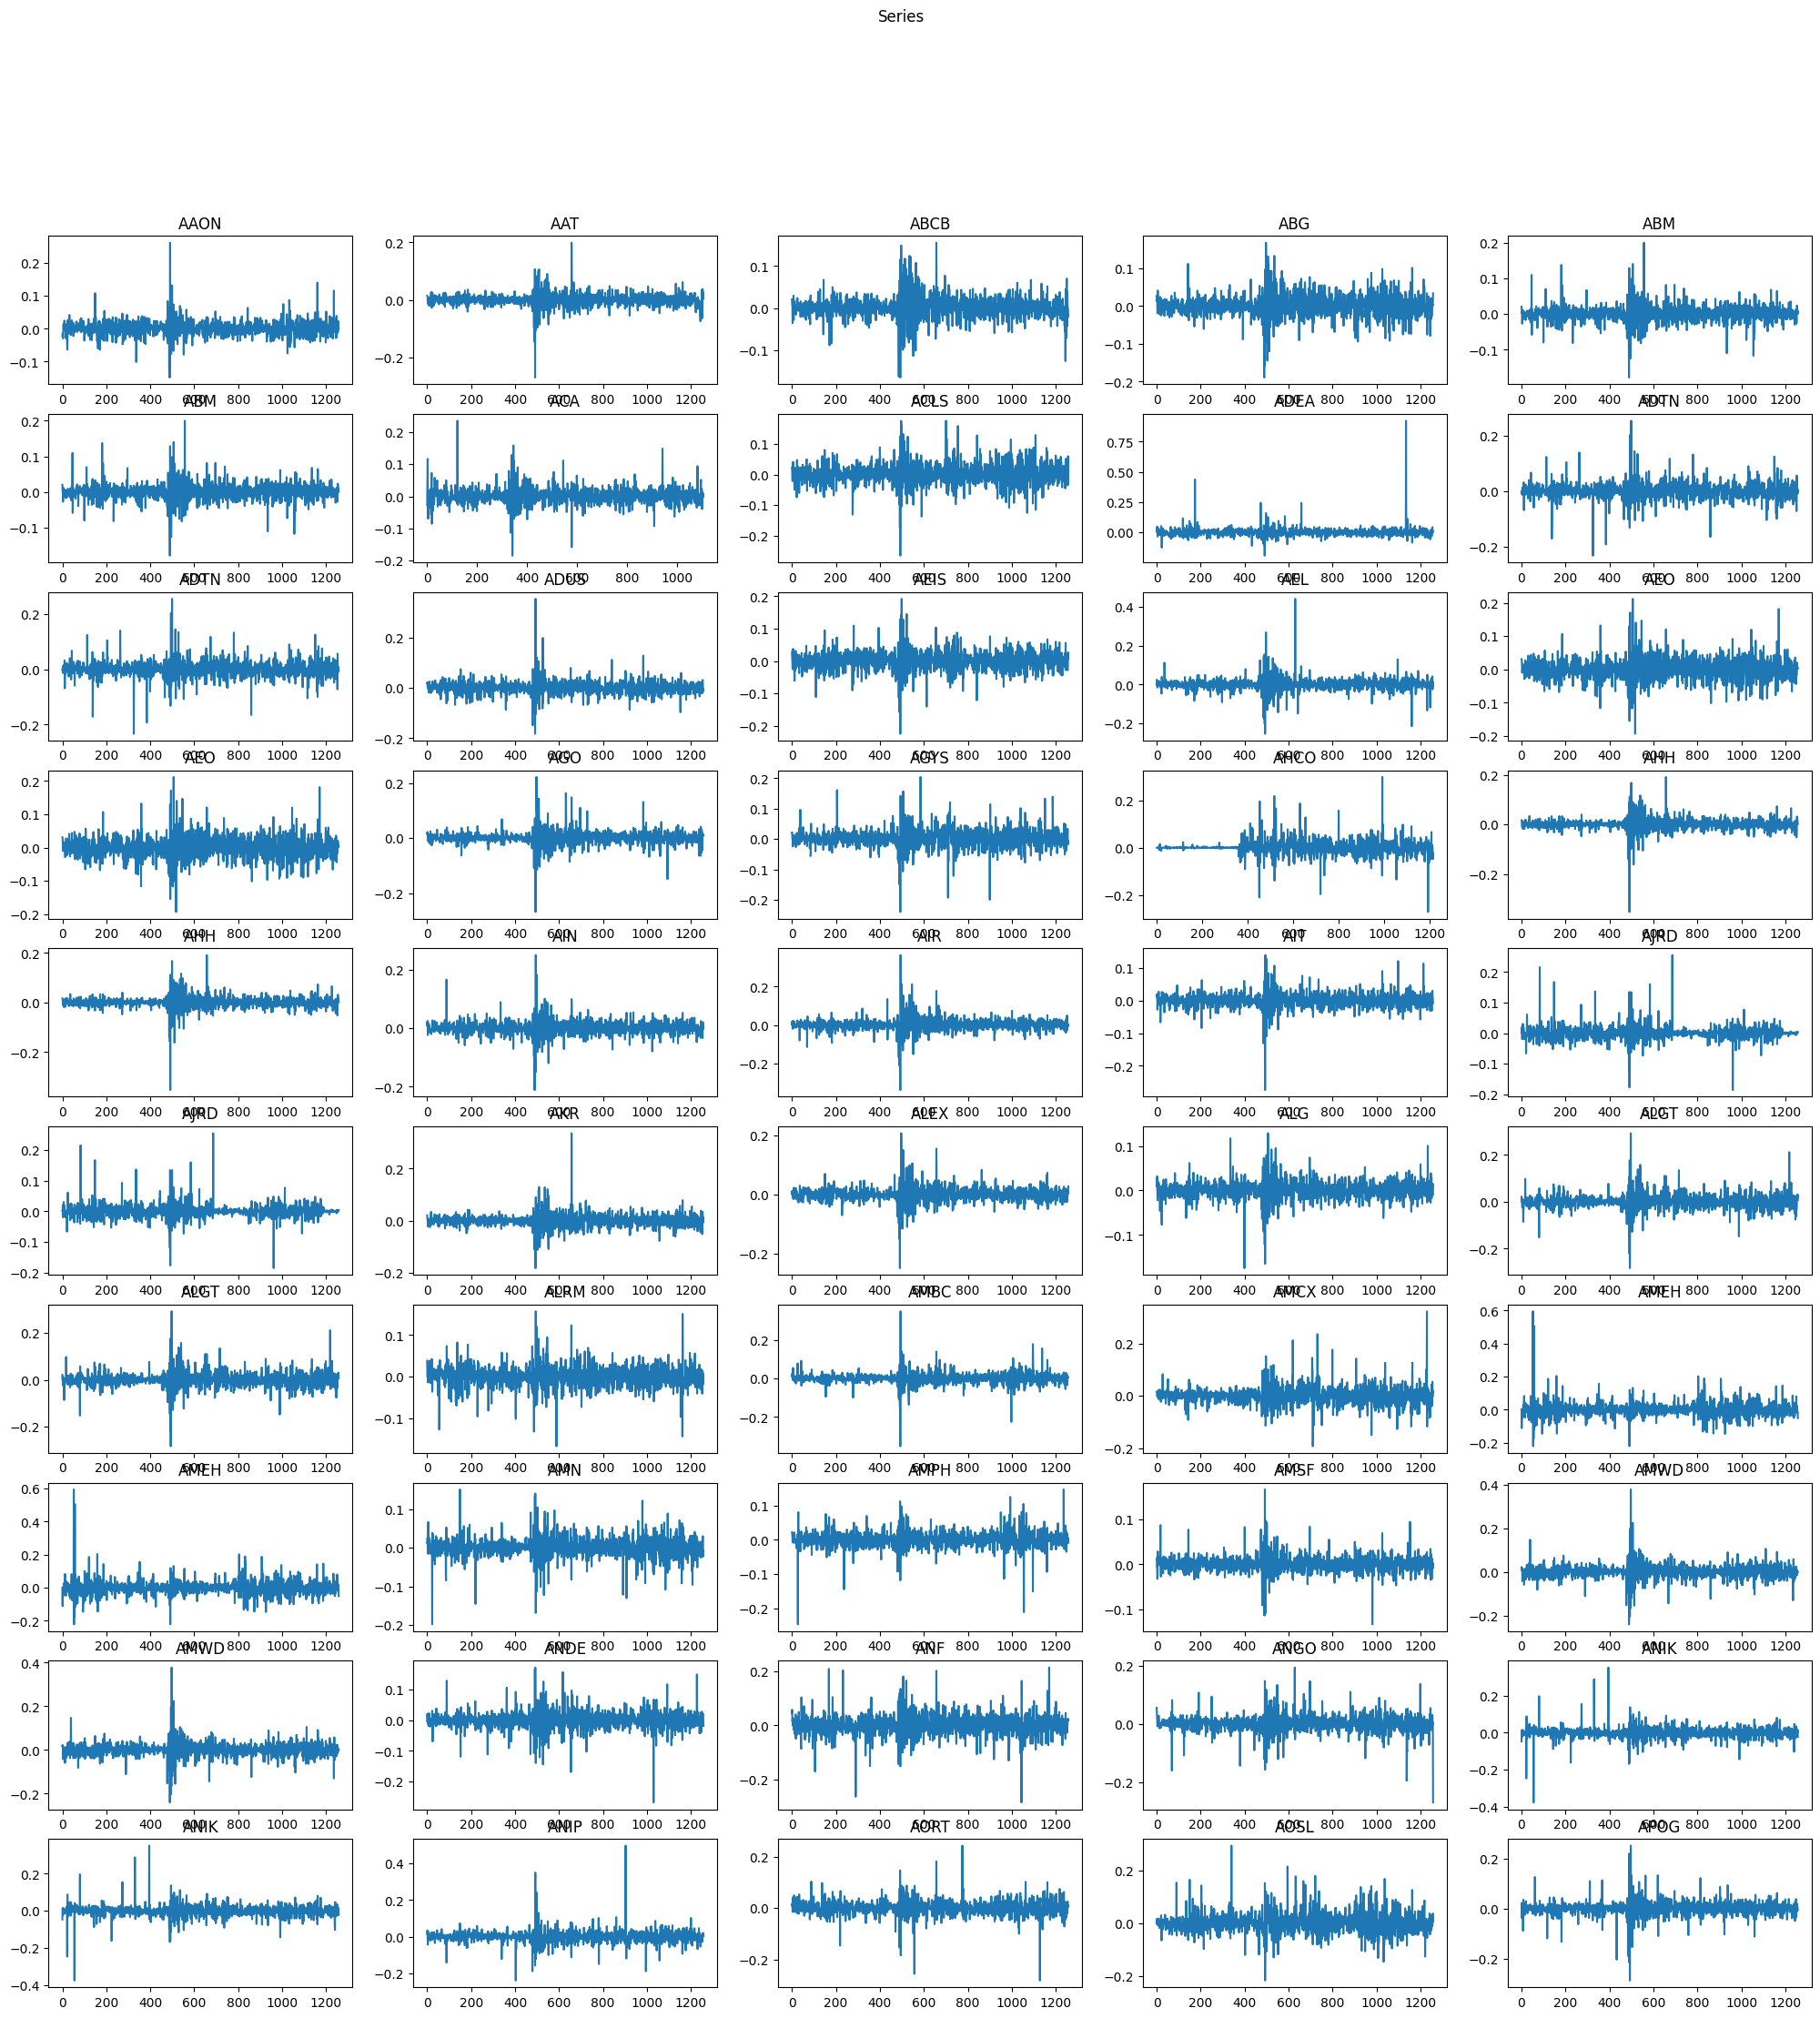

In [6]:
# plot the first 100 series
import matplotlib.pyplot as plt
data_to_plot = df_list_daily_return[:50]
fig, axs = plt.subplots(10,5,figsize=(25,25))
fig.suptitle('Series')
for i in range(10):
    for j in range(5):
        if i*4+j+1>len(data_to_plot):
            continue
        axs[i, j].plot(data_to_plot[i*4+j].values)
        axs[i, j].set_title(ticker_downloaded[i*4+j])
plt.show()

In [7]:
series_lengths = {len(series) for series in df_list_daily_return}
print(series_lengths)

{1216, 1123, 995, 968, 1256, 1258, 1257, 1230, 944, 1201, 1106, 1171, 1172, 1111, 1143, 1246}


#### Find the longest series

In [8]:
max_len = max(series_lengths)
longest_series = None
for series in df_list_daily_return:
    if len(series) == max_len:
        longest_series = series
print(len(longest_series))

1258


#### Reindex all series based on the longest one, and fill them with NaNs

In [9]:
problems_index = []

for i in range(len(df_list_daily_return)):
    if len(df_list_daily_return[i])!= max_len:
        problems_index.append(i)
        df_list_daily_return[i] = df_list_daily_return[i].reindex(longest_series.index)

In [10]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [11]:
nan_counter(df_list_daily_return)

16


#### Interpolate the NaNs

In [12]:
for i in problems_index:
    df_list_daily_return[i].interpolate(limit_direction="both",inplace=True, method='linear')

In [13]:
nan_counter(df_list_daily_return)

0


In [14]:
df_list_daily_return

[Date
 2018-04-03 00:00:00-04:00   -0.021534
 2018-04-04 00:00:00-04:00   -0.013755
 2018-04-05 00:00:00-04:00   -0.013947
 2018-04-06 00:00:00-04:00   -0.029703
 2018-04-09 00:00:00-04:00   -0.005831
                                ...   
 2023-03-24 00:00:00-04:00   -0.011911
 2023-03-27 00:00:00-04:00    0.017096
 2023-03-28 00:00:00-04:00    0.023381
 2023-03-29 00:00:00-04:00   -0.002106
 2023-03-30 00:00:00-04:00    0.001266
 Name: Daily Return, Length: 1258, dtype: float64,
 Date
 2018-04-03 00:00:00-04:00    0.014579
 2018-04-04 00:00:00-04:00    0.012024
 2018-04-05 00:00:00-04:00    0.011301
 2018-04-06 00:00:00-04:00   -0.013467
 2018-04-09 00:00:00-04:00   -0.011908
                                ...   
 2023-03-24 00:00:00-04:00    0.037015
 2023-03-27 00:00:00-04:00    0.010532
 2023-03-28 00:00:00-04:00    0.015634
 2023-03-29 00:00:00-04:00    0.026226
 2023-03-30 00:00:00-04:00    0.004444
 Name: Daily Return, Length: 1258, dtype: float64,
 Date
 2018-04-03 00:00:00-0

#### Normalize the data between 0 and 1

In [15]:
from sklearn.preprocessing import MinMaxScaler

for i in range(len(df_list_daily_return)):
    scaler = MinMaxScaler()
    df_list_daily_return[i] = MinMaxScaler().fit_transform(df_list_daily_return[i].values.reshape(-1,1))
    df_list_daily_return[i]= df_list_daily_return[i].reshape(len(df_list_daily_return[i]))

In [16]:
print("max: "+str(max(df_list_daily_return[0]))+"\tmin: "+str(min(df_list_daily_return[0])))
print(df_list_daily_return[0][:5])

max: 1.0	min: 0.0
[0.30975419 0.32866459 0.32819771 0.28989789 0.34792717]


#### Train the SOM

In [ ]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(df_list_daily_return))))

som = MiniSom(som_x, som_y,len(df_list_daily_return[0]), sigma=2, learning_rate = 0.0001)

som.random_weights_init(df_list_daily_return)
som.train(df_list_daily_return, 50000)

In [ ]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5)
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

#### Plot the clusters


In [ ]:
win_map = som.win_map(df_list_daily_return)
# Returns the mapping of the winner nodes and inputs
# plot clusters as point in a 2D map


plot_som_series_averaged_center(som_x, som_y, win_map)

#### Print the tickers of each cluster

In [ ]:
# Obtenir la carte des nœuds gagnants
win_map = som.win_map(df_list_daily_return)

# Initialiser une liste de labels pour chaque cluster
cluster_labels = [[] for i in range(som_x * som_y)]

# Parcourir la liste de données et extraire les labels correspondants à chaque cluster
for i, data in enumerate(df_list_daily_return):
    # Trouver le nœud gagnant correspondant à la série de données
    node = som.winner(data)
    # Ajouter le label correspondant à la série de données à la liste de labels du cluster correspondant
    cluster_labels[node[0] * som_y + node[1]].append(ticker_downloaded[i])

# Afficher les labels pour chaque cluster
for i in range(som_x * som_y):
    print("Cluster ", i+1, " : ", cluster_labels[i])

#### Plot all close values of a cluster

In [ ]:
cluster_number = 22

fig, axs = plt.subplots(1,1,figsize=(25,25))
fig.suptitle('Clusters')
for ticker in cluster_labels[cluster_number]:
    axs.plot(df_list[ticker_downloaded.index(ticker)]['Close'].values)
    axs.set_title(f"Cluster {cluster_number}")
axs.legend(cluster_labels[cluster_number])

In [ ]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5)
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

In [ ]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

## K-Means

In [ ]:
cluster_count = math.ceil(math.sqrt(len(df_list_daily_return)))
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(df_list_daily_return)

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(df_list_daily_return[i],c="gray",alpha=0.4)
                cluster.append(df_list_daily_return[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

In [ ]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(30,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
# print each tickers of all the clusters

for i in range(cluster_count):
    print("Cluster ", i, " : ", [ticker_downloaded[j] for j in range(len(labels)) if labels[j] == i])

In [ ]:
# plot each close value of a cluster
cluster_number = 18

fig, axs = plt.subplots(1,1,figsize=(25,25))
fig.suptitle('Clusters')
for i in range(len(labels)):
    if labels[i] == cluster_number:
        axs.plot(df_list[i]['Close'].values)
        # set legend to ticker
        axs.legend([ticker_downloaded[i]])
        axs.set_title(f"Cluster {cluster_number}")

## PCA : Principal Component Analysis, a dimensionality reduction technique

In [ ]:
pca = PCA(n_components=2)

df_list_daily_return_transformed = pca.fit_transform(df_list_daily_return)

In [ ]:
plt.figure(figsize=(25,25))
plt.scatter(df_list_daily_return_transformed[:,0],df_list_daily_return_transformed[:,1], s=300)
plt.show()

## K-Means on PCA

In [ ]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)

labels = kmeans.fit_predict(df_list_daily_return_transformed)

In [44]:
plt.figure(figsize=(25,25))
plt.scatter(df_list_daily_return_transformed[:, 0], df_list_daily_return_transformed[:, 1], c=labels, s=300)
plt.show()

TypeError: ignored

<Figure size 2500x2500 with 0 Axes>

In [ ]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(30,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
# print each close value of a cluster
cluster_number = 2

fig, axs = plt.subplots(1,1,figsize=(25,25))
fig.suptitle('Clusters')
for i in range(len(labels)):
    if labels[i] == cluster_number:
        axs.plot(df_list[i]['Close'].values)
        # set legend to ticker
        axs.legend([ticker_downloaded[i]])
        axs.set_title(f"Cluster {cluster_number}")

## Autoencoder

In [50]:
del model

In [17]:
import torch
import torch.nn as nn

class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.encoding = nn.Sequential(
              nn.Linear(hidden_size*2, 1000),
              nn.ReLU(),
              nn.Linear(1000, 500),
              nn.Tanh(),
              nn.Linear(500, 250),
              nn.ReLU(),

              nn.Linear(250, 150),
              nn.Tanh(),

              nn.Linear(150, 50),
              nn.ReLU(),

              nn.Linear(50, 20),
              nn.Tanh(),

              nn.Linear(20, 2)
          )
        for layer in [self.encoding[0], self.encoding[2], self.encoding[4],self.encoding[6],self.encoding[8],self.encoding[10],self.encoding[12]]:
            nn.init.xavier_uniform_(layer.weight)
       
    def forward(self, x):
        #print('Encoder shape: ', x.shape)
        _, (hidden, _) = self.lstm(x)
        #print('Encoder shape: ', hidden.view(x.size(0), -1).shape)
        x = hidden.view(x.size(0), -1)

        x = self.encoding(x)

        return x

class LSTMDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(1, 1, num_layers=num_layers, batch_first=True, bidirectional=False)
        self.decoding = nn.Sequential(
              nn.Linear(2, 20),
              nn.ReLU(),


              nn.Linear(20, 50),
              nn.Tanh(),

              nn.Linear(50, 150),
              nn.ReLU(),

              nn.Linear(150, 250),

              nn.Tanh(),

              nn.Linear(250, 500),
              nn.ReLU(),

              nn.Linear(500, 500),

              nn.Tanh(),

              nn.Linear(500, 1000),
              nn.ReLU(),


              nn.Linear(1000, 1258)
            
        )
       

    def forward(self, x):
        #print('Decoder shape: ', x.shape)
        x = self.decoding(x)

        #x = x.unsqueeze(1).repeat(1, 1258, 1)
        #print('Decoder shape1: ', x.shape)
        x = x.unsqueeze(-1)
        #print('x = ', x)
        #print('x = ', x.shape)
        x, _ = self.lstm(x)
        #print('Decoder shape2: ', x.shape)
        return x

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers= 1):
        super().__init__()
        self.encoder = LSTMEncoder(input_size, hidden_size, num_layers)
        self.decoder = LSTMDecoder(hidden_size*2, hidden_size, num_layers, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [22]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
model = LSTMAutoencoder(1,len(df_list_daily_return[0]),1)
model.to(device)


LSTMAutoencoder(
  (encoder): LSTMEncoder(
    (lstm): LSTM(1, 1258, batch_first=True, bidirectional=True)
    (encoding): Sequential(
      (0): Linear(in_features=2516, out_features=1000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1000, out_features=500, bias=True)
      (3): Tanh()
      (4): Linear(in_features=500, out_features=250, bias=True)
      (5): ReLU()
      (6): Linear(in_features=250, out_features=150, bias=True)
      (7): Tanh()
      (8): Linear(in_features=150, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=20, bias=True)
      (11): Tanh()
      (12): Linear(in_features=20, out_features=2, bias=True)
    )
  )
  (decoder): LSTMDecoder(
    (lstm): LSTM(1, 1, batch_first=True)
    (decoding): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=50, bias=True)
      (3): Tanh()
      (4): Linear(in_features=50, out_feature

In [23]:
device

'cpu'

In [24]:
# Create training dataset
X = torch.tensor(df_list_daily_return, dtype=torch.float32, device=device)
Y = torch.tensor(df_list_daily_return, dtype=torch.float32, device=device)

In [30]:
# train the model
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0025)
epochs = 2000
compteur = 0
loss_array = []
# reset the weights of the model
for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X[1].unsqueeze(0).unsqueeze(-1))
    single_loss = loss_function(y_pred.squeeze(-1).squeeze(0),X[1])
    loss_array.append(single_loss.item())


    single_loss.backward()

    optimizer.step()
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    # plot the loss of the whole training

    if compteur == len(X[1])-1:
        compteur = 0
    else:
        compteur += 1
# plot the loss of the whole training with loss_array
#reset plt to plot the loss
plt.clf()

loss_array_smoothed = pd.Series(loss_array).ewm(span=1000).mean()
plt.plot(loss_array_smoothed)
plt.show()

epoch:   0 loss: 0.00042291
epoch:   1 loss: 0.00195588
epoch:   2 loss: 0.00128071
epoch:   3 loss: 0.00145044
epoch:   4 loss: 0.00090309
epoch:   5 loss: 0.00102258
epoch:   6 loss: 0.00090827
epoch:   7 loss: 0.00081923
epoch:   8 loss: 0.00086720
epoch:   9 loss: 0.00090070
epoch:  10 loss: 0.00080334
epoch:  11 loss: 0.00071102
epoch:  12 loss: 0.00071999
epoch:  13 loss: 0.00074267
epoch:  14 loss: 0.00069510
epoch:  15 loss: 0.00061146
epoch:  16 loss: 0.00055330
epoch:  17 loss: 0.00053491
epoch:  18 loss: 0.00053002
epoch:  19 loss: 0.00052021
epoch:  20 loss: 0.00050847
epoch:  21 loss: 0.00050676
epoch:  22 loss: 0.00051711
epoch:  23 loss: 0.00052032
epoch:  24 loss: 0.00050381
epoch:  25 loss: 0.00048037
epoch:  26 loss: 0.00046462
epoch:  27 loss: 0.00045764
epoch:  28 loss: 0.00045463
epoch:  29 loss: 0.00045220
epoch:  30 loss: 0.00044971
epoch:  31 loss: 0.00044807
epoch:  32 loss: 0.00044782
epoch:  33 loss: 0.00044789
epoch:  34 loss: 0.00044627
epoch:  35 loss: 0.0

KeyboardInterrupt: ignored

In [43]:
y_pred = model.encoder(X[1].unsqueeze(0).unsqueeze(-1))
print(X.shape)


torch.Size([569, 1258])


In [ ]:
df_list_daily_return_transformed = []
compteur = 0
for x in X:
  print(compteur, '/', len(X))
  df_list_daily_return_transformed.append(model.encoder(x.unsqueeze(0).unsqueeze(-1)))
  compteur +=1 

0 / 569
1 / 569
2 / 569
3 / 569
4 / 569
5 / 569
6 / 569
7 / 569
8 / 569
9 / 569
10 / 569
11 / 569
12 / 569
13 / 569
14 / 569
15 / 569
16 / 569
17 / 569
18 / 569
19 / 569
20 / 569
21 / 569
22 / 569
23 / 569
24 / 569
25 / 569
26 / 569
27 / 569
28 / 569
29 / 569
30 / 569
31 / 569
32 / 569
33 / 569
34 / 569
35 / 569
36 / 569
37 / 569
38 / 569
39 / 569
40 / 569
41 / 569
42 / 569
43 / 569
44 / 569
45 / 569
46 / 569
47 / 569
48 / 569
49 / 569
50 / 569
51 / 569
52 / 569
53 / 569
54 / 569
55 / 569
56 / 569
57 / 569
58 / 569
59 / 569
60 / 569
61 / 569
62 / 569
63 / 569
64 / 569
65 / 569
66 / 569
67 / 569
68 / 569
69 / 569
70 / 569
71 / 569
72 / 569


torch.Size([1, 1258, 1])


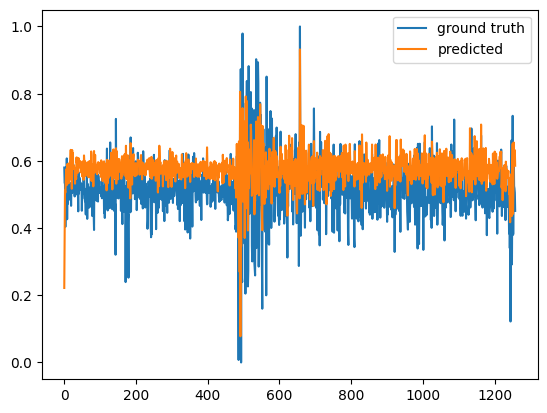

In [32]:
# test the model on the training data
predicted_training = []
y_values_as_list = []



# encode the training data

y_pred = model(X[2].unsqueeze(0).unsqueeze(-1))
train_results = y_pred.detach()
#
print(y_pred.detach().cpu().shape)
y_pred = y_pred.cpu()
# plot with matplotlib expected vs predicted, the x axis is the years

#train_data['Close'].plot()
# plot the predicted values as point
# remove even index
# put data every number_of_days, and 0 elsewhere to plot the points
#divide by 2 x axis to plot the points
plt.plot(X[2].cpu(),label='ground truth')


plt.plot(y_pred.squeeze(-1).squeeze(0).detach().cpu(),label='predicted')
plt.legend()




plt.show()